<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Bayesian Modeling Lab</div>
<div style="text-align: right">Dino Konstantopoulos, 13 February 2019, with material from John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck</div>
<div style="text-align: right">[(URL)](https://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression)</div>

# Lab: Getting started with probabilistic programming

In probabilistic programming, we specify variables as probability distributions and condition variables on other variables and on observations. It's a powerful tool for building data models.
 
`PyMC3` is an open source probabilistic programming framework written in Python that used to use Theano (latest version, not anymore - theano is [dead](https://twitter.com/twiecki/status/913508217514283008) to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to C for increased speed.

If you still have problems running theano (you should try uninstalling and installing different versions, with help from your TAs), then please run the notebook on [Google](https://colab.research.google.com/notebook) or on [Azure](https://notebooks.azure.com/).

PyMC3 include next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger data models. 


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## Linear Regression

Consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $μ$ that is a linear function of two predictor variables, $X1$ and $X2$.

$$\begin{split}\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}\end{split}$$

$α$ is the intercept, and $β_i$ is the coefficient for covariate $X_i$, while $σ$ represents the observation error. Since we are constructing a **Bayesian model**, we must assign a **prior distribution** to the unknown variables in the model. We choose **zero-mean normal priors** with variance of 100 for both regression coefficients, which corresponds to **weak information** regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $σ$.

$$\begin{split}\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}\end{split}$$

#### Let's simulate some data:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor (independent) variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome (dependent) variable
Y = alpha + beta[0]*X1 + beta[1]*X2

Let's plot the data.
```python
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');
```

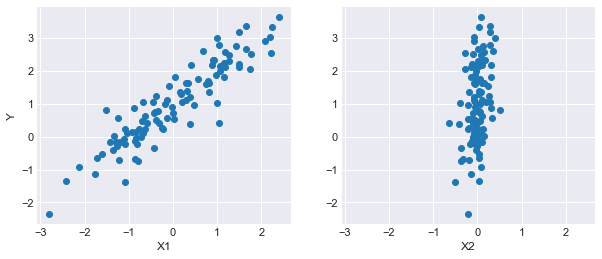

In [8]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

Now let's add some noise.
```python
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma
```

In [9]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor (independent) variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome (dependent) variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

and plot.

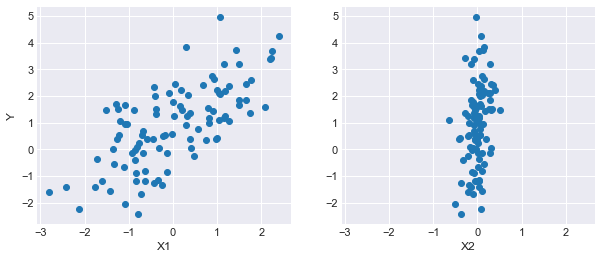

In [10]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

#### Let's build a Bayesian model

For help on any PyMC3 API, run `help()`. For example, for help on the Normal API:
```python
help(pm.Normal)
```

In [11]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

# Create a new Model object which is a container for the model random variables
basic_model = pm.Model()

# Create a context manager, with our basic_model as the context, that includes all statements until the indented block ends.
# This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model 
# behind the scenes. Without this context manager idiom, we would be forced to manually associate each of the variables 
# with basic_model right after we create them 
with basic_model:

    # Priors for unknown model parameters: Create stochastic random variables with Normal prior distributions 
    # for the regression coefficients, with a mean of 0 and standard deviation of 10, and a half-normal distribution 
    # for the standard deviation of the observations.
    # Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, 
    # are available in PyMC3.
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
                      
    # The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. 
    # The shape argument is available for all distributions and specifies the length or shape of the random variable, 
    # but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, 
    # or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix 
    # values)

    # Expected value of outcome: This creates a *deterministic* random variable, which implies that its value is completely 
    # determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ 
    # values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the 
    # predictor variables
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    # Y_obs is a stochastic variable that we call an *observed* stochastic, and represents the data likelihood of the model.
    # It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, 
    # indicates that the values for this variable were *observed*, and should not be changed by any fitting algorithm 
    # applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Running on PyMC3 v3.6


#### Posterior estimates

Having completely specified our model, the next step is to obtain **posterior estimates** for the **unknown variables** in the model. 

Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. 

We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: 
* Finding the maximum a posteriori (MAP) point using optimization methods
* Computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### MAP

The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values (like a probability distribution).

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of *other* optimization algorithms from the `scipy.optimize` module. For example:
```python
map_estimate = pm.find_MAP(model=basic_model, method='powell')
```

Most techniques for finding the MAP estimate also only find a **local optimum** (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

In [12]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1063.46it/s] 


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

MAP is of limited because there is no **associated estimate of uncertainty** produced with the MAP estimates. 

A simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, give us estimates **as well as** uncertainties.

For PyMC3, method auto-assignment is based on the attributes of each variable in the model. In general:

*    Binary variables will be assigned to BinaryMetropolis
*    Discrete variables will be assigned to Metropolis
*    Continuous variables will be assigned to NUTS

PyMC3’s **most capable** step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. 



In [13]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3379.29draws/s]


The `trace` object contains the samples collected, in the order they were collected. It can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample:

In [14]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 2814.59draws/s]


#### Posterior analysis

PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using `traceplot`.

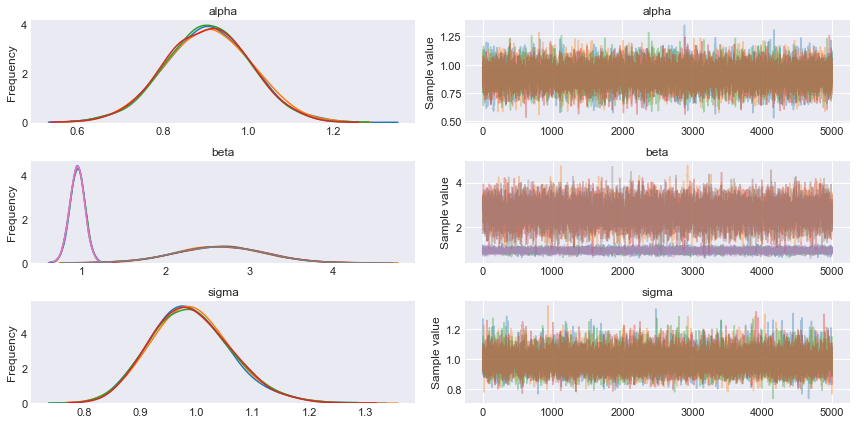

In [15]:
pm.traceplot(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

The summary function provides a text-based output of common posterior statistics:

In [16]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.0,0.72,1.11,19979.81,1.0
beta__0,0.95,0.09,0.0,0.78,1.13,19107.16,1.0
beta__1,2.65,0.52,0.0,1.60,3.65,16191.09,1.0
sigma,0.99,0.07,0.0,0.86,1.13,17898.13,1.0


## Use Case: Stochastic volatility

The distribution of market returns is highly non-normal, which makes sampling volatilities difficult.
 
Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time.

$r$, the daily return series, is modeled with a [Student-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process.

$$\begin{split}\begin{aligned}
  \nu &\sim exp(0.1) \\
  \sigma &\sim exp(50) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^2) \\
  log(r_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}\end{split}$$

In [18]:
import pandas as pd
returns = pd.read_csv('SP500b.csv', parse_dates=True, index_col=0)
len(returns)

401

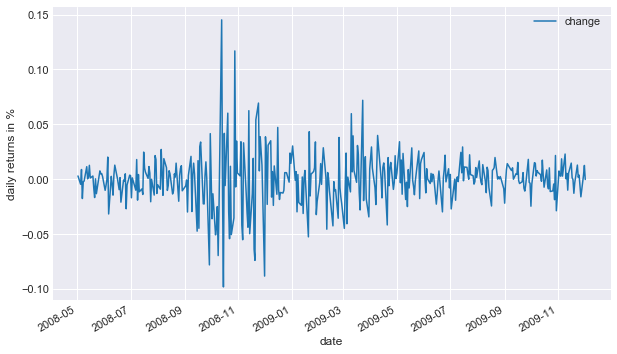

In [19]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

#### Model

Our Model employs the following distributions: the Exponential distribution for the ν and σ priors, the Student-T (StudentT) distribution for the distribution of returns, and a `GaussianRandomWalk` for the prior for the latent volatilities.

A Gaussian random walk is a vector-valued distribution where the values of the vector form a random normal walk of a certain length n. The scale of the innovations of the random walk is sigma, specified in terms of the standard deviation of the normally distributed innovations.

We transform the log volatility process $s$ into the volatility process by $\sqrt{e^{-2s}}$. Here, exp is a Theano function, rather than the corresponding function in NumPy. Theano provides a larger subset of mathematical functions than NumPy.

In [20]:
# Create a new Model object which is a container for the model random variables
sp500_model = pm.Model()

In [21]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns['change'])

Let's simulate.

In [22]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:38<00:00, 26.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Check samples by looking at the traceplot for nu and sigma:

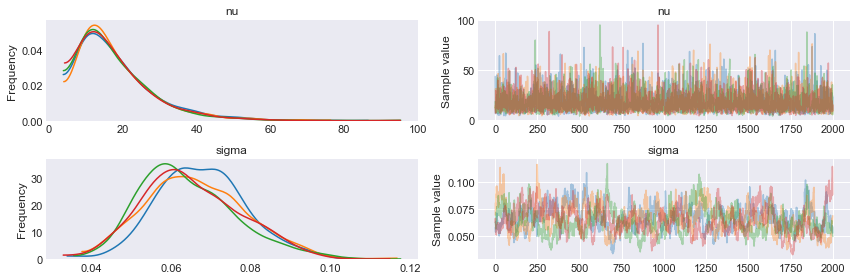

In [23]:
pm.traceplot(trace, varnames=['nu', 'sigma']);

Now, plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. 

Each is rendered partially transparent (via the alpha argument in Matplotlib’s plot function) so the regions where many paths overlap are shaded more darkly.

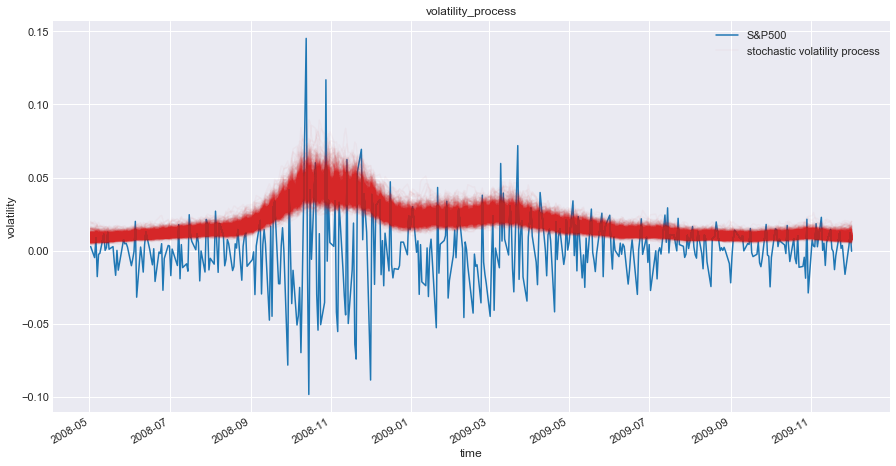

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

The model correctly infers the increase in volatility during the 2008 financial crash. 

Note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, correctly infers the posterior distribution.